In [1]:
import intake
import xarray as xr
import xshelftransects
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

url_google = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"

catalog = intake.open_esm_datastore(url_google)
search_result = catalog.search(source_id = "ACCESS-ESM1-5",
                               experiment_id=['historical'], 
                               variable_id=['deptho', "thetao"]).search(member_id = ['r1i1p1f1'])

ds_dict = search_result.to_dataset_dict(zarr_kwargs={'consolidated': True})

ds = xr.merge([ds_dict['CMIP.CSIRO.ACCESS-ESM1-5.historical.Ofx.gn'], ds_dict['CMIP.CSIRO.ACCESS-ESM1-5.historical.Omon.gn']])
ds = ds[["deptho", "thetao"]].isel(member_id = 0, dcpp_init_year = 0, time = slice(0, 24))


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


<div><progress max="2" value="2"></progress> 100.00% [2/2 00:24&lt;00:00]</div>

/var/folders/vt/sjvxnnwn7y51hx1c814wrxn80000gn/T/ipykernel_29932/2861090667.py:18: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.merge([ds_dict['CMIP.CSIRO.ACCESS-ESM1-5.historical.Ofx.gn'], ds_dict['CMIP.CSIRO.ACCESS-ESM1-5.historical.Omon.gn']])
/var/folders/vt/sjvxnnwn7y51hx1c814wrxn80000gn/T/ipykernel_29932/2861090667.py:18: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_

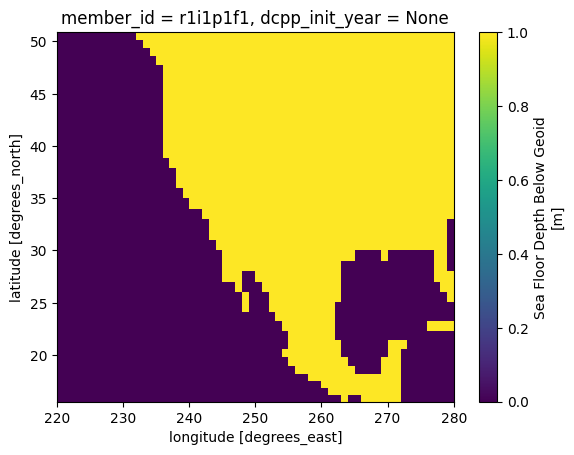

In [2]:
ds_so = ds.isel(j = slice(180, 220), i = slice (140, 200)) #just get california coast region
ds_so = ds_so.rename({"latitude":"lat", "longitude":"lon", "lev":"z_l"}) #rename dimenstions

coast_mask = (ds_so.deptho.fillna(0.0) <= 10.0)

boundary_mask = coast_mask
boundary_mask.plot(x = "lon", y = "lat")

In [30]:
transects, geometry = xshelftransects.cross_shelf_transects(
    ds_so,
    "thetao",                    # str | list[str]
    boundary_mask,          # DataArray; contour(level=0.5) defines transect_length=0
    transect_length=np.arange(0.0, 200e3 + 2e3, 5e3),
    transect_spacing=200e3,
    crs="EPSG:3857",
    engine="xesmf",
    method="bilinear",
    reuse_weights=False,
    regridder=None,
    lon_name="lon",
    lat_name="lat",
    return_geometry=True,
)

/Users/anthonymeza/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/Documents/GitHub/xshelftransects/src/xshelftransects/sampling.py:163: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'loc' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  return vloc_ds.assign_coords(loc=mi).unstack("loc").assign_coords(s_m=("section", np.asarray(s_m)))


/Users/anthonymeza/miniforge3/envs/xshelftransects/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1631: UserWarning: The following kwargs were not used by contour: 'shading'
  result = super().contourf(*args, **kwargs)


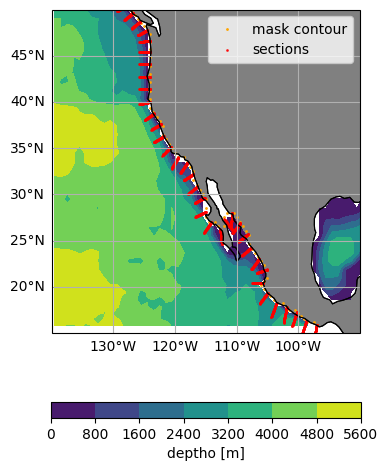

In [31]:
# # Plot geometry
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-140, -90, 15, 50], crs=ccrs.PlateCarree())
ax.coastlines(resolution="110m", linewidth=0.8)
ax.coastlines(resolution="110m", linewidth=0.8)
ax.add_feature(cartopy.feature.LAND.with_scale('110m'), facecolor='grey')

gl = ax.gridlines(draw_labels = True); gl.top_labels = False; gl.right_labels = False

ax.set_aspect(1.5)
m = ax.contourf(ds_so["lon"], ds_so["lat"], ds_so["deptho"], transform=ccrs.PlateCarree(), shading="auto")
fig.colorbar(m, ax=ax, shrink=0.5, label="deptho [m]", orientation = "horizontal")
ax.scatter(geometry["contour_lon"], geometry["contour_lat"], transform=ccrs.PlateCarree(), s=1, color="orange", 
           label = "mask contour")


for i in range(0, transects.sizes["section"]):
    ax.scatter(transects["lon"].isel(section=i), transects["lat"].isel(section=i),
            transform=ccrs.PlateCarree(), s=1, color="red", alpha=0.8, label = "sections")
    if i == 0:
        ax.legend()




(43.0, 200.0)

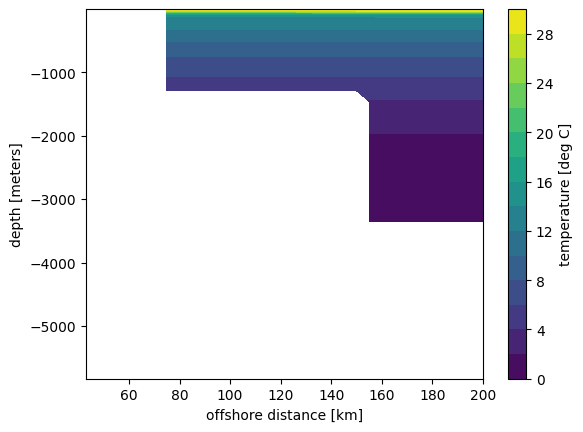

In [38]:
single_transect = transects.isel(section = 32).mean("time").compute() 

fig, ax = plt.subplots()
cb = ax.contourf(single_transect["transect_length"] / 1e3, -single_transect["z_l"], single_transect, levels = 15)
fig.colorbar(cb, label = "temperature [deg C]")
ax.set_ylabel("depth [meters]")
ax.set_xlabel("offshore distance [km]")
ax.set_xlim(43, None)


(43.0, 200.0)

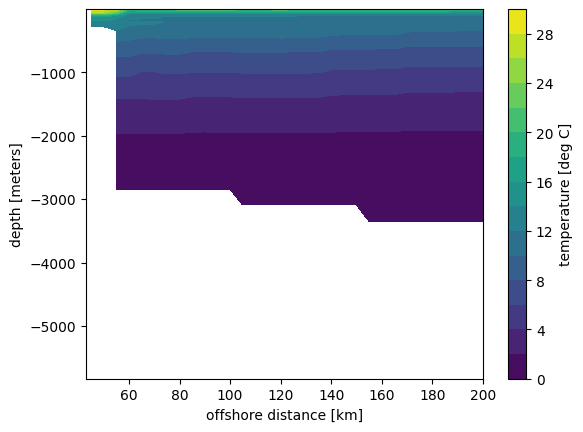

In [39]:
avg_transects = transects.mean("section").mean("time").compute() 

fig, ax = plt.subplots()
cb = ax.contourf(avg_transects["transect_length"] / 1e3, -avg_transects["z_l"], avg_transects, levels = 15)
fig.colorbar(cb, label = "temperature [deg C]")
ax.set_ylabel("depth [meters]")
ax.set_xlabel("offshore distance [km]")
ax.set_xlim(43, None)


Text(0.5, 0, 'section #')

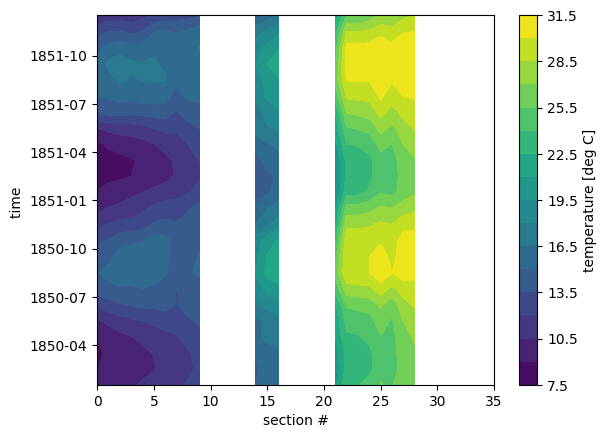

In [41]:
avg_transects = transects.where(transects.depth < 2000).isel(z_l = 0).mean("transect_length")

fig, ax = plt.subplots()
cb = ax.contourf(avg_transects["section"], avg_transects["time"], avg_transects, levels = 15)
fig.colorbar(cb, label = "temperature [deg C]")
ax.set_ylabel("time ")
ax.set_xlabel("section #")